In [84]:
import torch
from torch import nn
from torch.utils.data import DataLoader

import torchvision
from torchvision import transforms, models

import numpy as np
import matplotlib.pyplot as plt

from utils import *

import json

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [86]:
from torchvision.models import resnet18
from torch.optim.swa_utils import AveragedModel


model_name = "resnet_noise"
name1 = "Noise"

model1 = resnet18(num_classes=50)
sd = torch.load("good_pretrained_models/" + model_name)
if "swa" in model_name:
#     print(sd.keys())
    ks = list(sd.keys())
    for key in ks:
        if "module." not in key:
            continue
            
        nk = key.replace("module.", "")
        sd[nk] = sd[key]
        del sd[key]
    del sd["n_averaged"]

model1.load_state_dict(sd)
loss_fn = nn.CrossEntropyLoss()
model1 = model1.to(device)

In [87]:
model_name = "resnet_swa"
name2 = "SWA"

model2 = resnet18(num_classes=50)
sd = torch.load("good_pretrained_models/" + model_name)
if "swa" in model_name:
#     print(sd.keys())
    ks = list(sd.keys())
    for key in ks:
        if "module." not in key:
            continue
            
        nk = key.replace("module.", "")
        sd[nk] = sd[key]
        del sd[key]
    del sd["n_averaged"]
    
model2.load_state_dict(sd)
loss_fn = nn.CrossEntropyLoss()
model2 = model2.to(device)

In [88]:
import data_loading
dl_train, dl_val = data_loading.get_data_loaders()

In [89]:
dl, test_dl = data_loading.get_data_loaders(train_folder="Stratified_sample", batch_size=64)

In [90]:
test(dl, model1, loss_fn)

(0.0896408287808299, 0.9628)

In [91]:
test(dl_val, model1, loss_fn)

(4.804960823059082, 0.4004)

In [92]:
# num_classes = 100
# train_set, test_set = load_cifar(num_classes)

# # wrap data inside a DataLoader object
# batch_size = 128
# dl = DataLoader(train_set, batch_size=batch_size, shuffle=False)

In [93]:
# model1 = models.resnet18(weights='IMAGENET1K_V1')
# model1.fc = nn.Linear(512, num_classes, bias=True)

# model2 = models.resnet18(weights='IMAGENET1K_V1')
# model2.fc = nn.Linear(512, num_classes, bias=True)

# model1.to(device)
# model2.to(device)

# loss_fn = torch.nn.CrossEntropyLoss()

# optimizer1 = torch.optim.AdamW(model1.parameters())
# train(dl, model1, loss_fn, optimizer1)

# # do one epoch on model2
# optimizer2 = torch.optim.AdamW(model2.parameters())
# train(dl, model2, loss_fn, optimizer2)

# Traverse loss landscape along a straight line

In [94]:
# batch_size = 128
# dl = DataLoader(train_set, batch_size=batch_size, shuffle=False)
# test_dl = DataLoader(test_set, batch_size=batch_size, shuffle=False)

In [95]:
print('Training data:')
test(dl, model1, loss_fn), test(dl, model2, loss_fn)

Training data:


((0.08867220341635403, 0.9628), (0.01444916928095381, 0.9928))

In [96]:
print('Test data:')
test(test_dl, model1, loss_fn), test(test_dl, model2, loss_fn)

Test data:


((4.848509919643402, 0.4004), (3.636410176753998, 0.4756))

In [97]:
nsteps = 50

lst1, l2_distance, l2_convs, l2_bn = traverse(dl, model1, model2, loss_fn, nsteps, chkpt='chkpt.pt')
lst2, _, _, _ = traverse(test_dl, model1, model2, loss_fn, nsteps, chkpt='chkpt.pt')

In [98]:
losses = [i[0] for i in lst1]
test_losses = [i[0] for i in lst2]

In [99]:
print((l2_convs))

tensor(3.6257e-05, device='cuda:0')


In [100]:
accs = [i[1] for i in lst1]
test_accs = [i[1] for i in lst2]

In [101]:
traverse_json = {
    'nsteps': nsteps,
    'losses': losses,
    'test_losses': test_losses,
    'accuracies': accs,
    'test_accuracies': test_accs,
    'l2_distance': float(l2_distance),
    'l2_convs': float(l2_convs),
    'l2_bn': float(l2_bn),
    'model1': name1,
    'model2': name2
}

path = f"Logged robustness/traverse_{name1}_{name2}.json"


with open(path, "w") as file:
    json.dump(traverse_json, file)

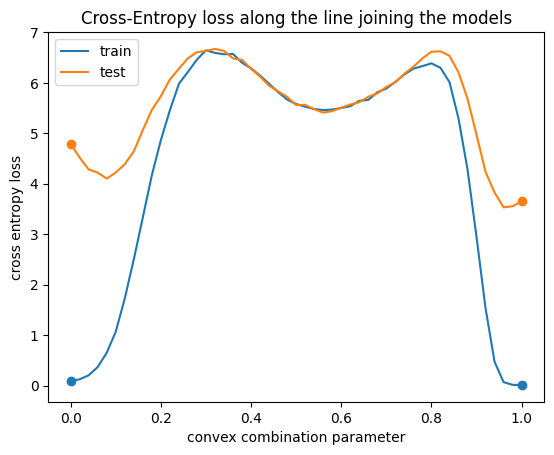

In [102]:
x_axis = np.linspace(0,1, nsteps+1)

plt.scatter([0, 1], [losses[0], losses[-1]])
plt.scatter([0, 1], [test_losses[0], test_losses[-1]])
plt.plot(x_axis,losses, label='train')
plt.plot(x_axis, test_losses, label='test')
plt.title("Cross-Entropy loss along the line joining the models")
plt.xlabel("convex combination parameter")
plt.ylabel("cross entropy loss")
plt.legend()
plt.savefig(f"Figure/Traverse {name1}-{name2} loss")
plt.show()

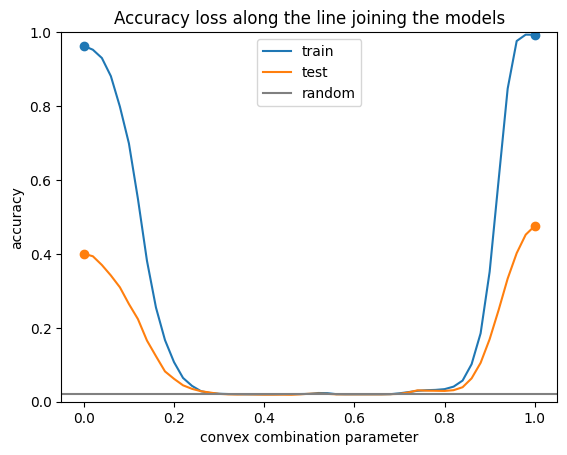

In [103]:
x_axis = np.linspace(0,1, nsteps+1)

plt.scatter([0, 1], [accs[0], accs[-1]])
plt.scatter([0, 1], [test_accs[0], test_accs[-1]])
plt.plot(x_axis,accs, label='train')
plt.plot(x_axis, test_accs, label='test')
plt.xlabel("convex combination parameter")
plt.ylim(0,1)
plt.ylabel("accuracy")
plt.axhline(0.02, color="grey", label="random")
plt.title("Accuracy loss along the line joining the models")
plt.legend()
plt.savefig(f"Figure/Traverse {name1}-{name2} accuracy")
plt.show()

## Fast Gradient Signed Method attack

In [104]:
# epss = [0.0, 0.001, 0.005, 0.01, 0.05]


epss = [x/1000 for x in range(0, 31)]
print(epss)
# lists are better for ordering purposes + matplotlib complains
losses, test_losses, accs, test_accs = [],[],[],[]
max_b = None


# epss = [0.01]
for eps in epss:
    print(eps)
    acc, loss = test_fgsm(dl, model1, eps, max_b, loss_fn)
    test_acc, test_loss = test_fgsm(test_dl, model1, eps, max_b, loss_fn)

    losses.append(loss)
    test_losses.append(test_loss)
    accs.append(acc)
    test_accs.append(test_acc)

[0.0, 0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009, 0.01, 0.011, 0.012, 0.013, 0.014, 0.015, 0.016, 0.017, 0.018, 0.019, 0.02, 0.021, 0.022, 0.023, 0.024, 0.025, 0.026, 0.027, 0.028, 0.029, 0.03]
0.0
0.001
0.002
0.003
0.004
0.005
0.006
0.007
0.008
0.009
0.01
0.011
0.012
0.013
0.014
0.015
0.016
0.017
0.018
0.019
0.02
0.021
0.022
0.023
0.024
0.025
0.026
0.027
0.028
0.029
0.03


In [105]:
losses = [float(x) for x in losses]
test_losses = [float(x) for x in test_losses]

In [106]:
fgsm_json = {
    'epss': epss,
    'losses': losses,
    'test_losses': test_losses,
    'accuracies': accs,
    'test_accuracies': test_accs,
    'model': name1,
}

path = f"Logged robustness/fgsm_{name1}.json"


with open(path, "w") as file:
    json.dump(fgsm_json, file)

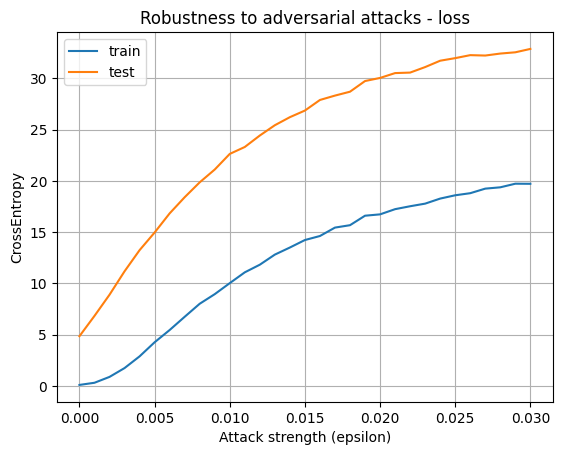

In [110]:
plt.plot(epss, losses, label='train')
plt.plot(epss, test_losses, label='test')
plt.xlabel("Attack strength (epsilon)")
plt.ylabel("CrossEntropy")
plt.title("Robustness to adversarial attacks - loss")
plt.legend()
plt.grid()
plt.savefig(f"FGSM {name1} loss")
plt.show()

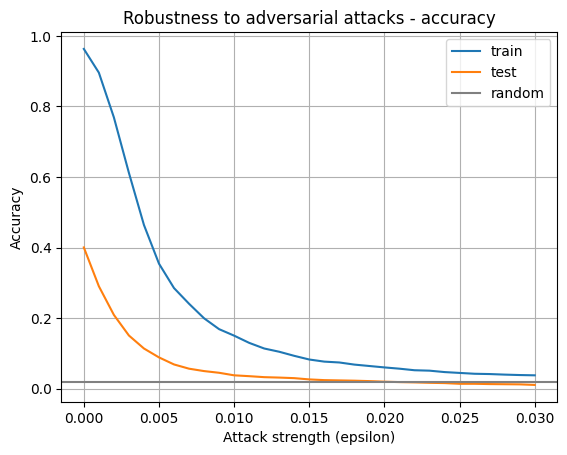

In [111]:
plt.plot(epss, accs, label='train')
plt.plot(epss, test_accs, label='test')
plt.title("Robustness to adversarial attacks - accuracy")
plt.xlabel("Attack strength (epsilon)")
plt.ylabel("Accuracy")

plt.axhline(0.02, color="grey", label="random")
plt.legend()
plt.grid()

plt.savefig(f"FGSM {name1} accuracy")
plt.show()

# Classification with corrupted images

In [112]:
sigmas = [0.0, 0.05, .1, .15, .2, .25, .3, .4, .5, .8]
sigmas = [x/100 for x in range(0, 101, 5)]
max_b = None
iters = 10

losses, accs = denoising(model1, dl, loss_fn, sigmas, iters=iters, max_b=max_b)
test_losses, test_accs = denoising(model1, test_dl, loss_fn, sigmas, iters=iters, max_b=max_b)

# for sigma in sigmas:
#     losses[sigma] = sum(losses[sigma]) / len(losses[sigma])
#     test_losses[sigma] = sum(test_losses[sigma]) / len(test_losses[sigma])

#     accs[sigma] = sum(accs[sigma]) / len(accs[sigma])
#     test_accs[sigma] = sum(test_accs[sigma]) / len(test_accs[sigma])

In [113]:
losses

{0.0: tensor(0.0886),
 0.05: tensor(0.0628),
 0.1: tensor(0.2166),
 0.15: tensor(1.2201),
 0.2: tensor(2.9532),
 0.25: tensor(4.8713),
 0.3: tensor(6.7039),
 0.35: tensor(8.3362),
 0.4: tensor(9.8165),
 0.45: tensor(11.1124),
 0.5: tensor(12.0956),
 0.55: tensor(12.9749),
 0.6: tensor(13.6246),
 0.65: tensor(14.1505),
 0.7: tensor(14.5476),
 0.75: tensor(14.8365),
 0.8: tensor(15.0160),
 0.85: tensor(15.2368),
 0.9: tensor(15.3021),
 0.95: tensor(15.3823),
 1.0: tensor(15.4789)}

In [114]:
losses_list = []
test_losses_list = []
accs_list = []
test_accs_list = []

for k in sigmas:
    losses_list.append(float(losses[k]))
    test_losses_list.append(float(test_losses[k]))
    accs_list.append(accs[k])
    test_accs_list.append(test_accs[k])

losses = losses_list
test_losses = test_losses_list
accs = accs_list
test_accs = test_accs_list 


In [115]:
corrupted_json = {
    'sigmas': sigmas,
    'iters': iters,
    'losses': losses,
    'test_losses': test_losses,
    'accuracies': accs,
    'test_accuracies': test_accs,
    'model': name1,
}

path = f"Logged robustness/corrupted_{name1}.json"


with open(path, "w") as file:
    json.dump(corrupted_json, file)

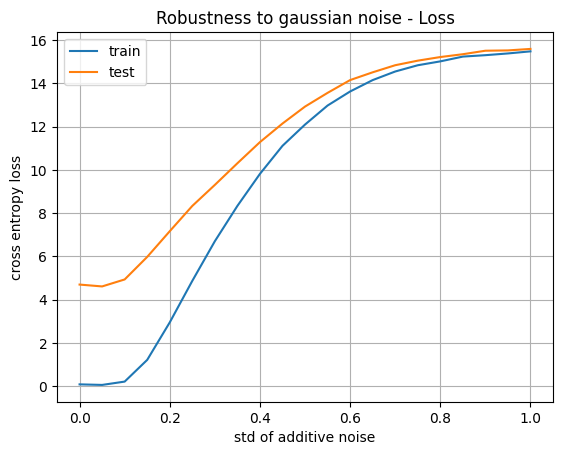

In [116]:
plt.plot(sigmas, losses, label='train')
plt.plot(sigmas, test_losses, label='test')
plt.title('Robustness to gaussian noise - Loss')
plt.xlabel("std of additive noise")
plt.ylabel("cross entropy loss")
plt.legend()
plt.grid()
plt.savefig(f"Figure/Corrupted {name1} loss")
plt.show()

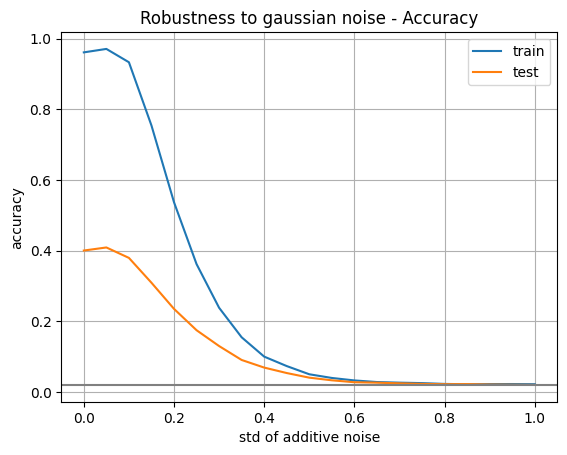

In [117]:
plt.plot(sigmas, accs, label='train')
plt.plot(sigmas, test_accs, label='test')
plt.title('Robustness to gaussian noise - Accuracy')
plt.xlabel("std of additive noise")
plt.ylabel("accuracy")
plt.legend()
plt.grid()
plt.axhline(0.02, color="grey", label="random")
plt.savefig(f"Figure/Corrupted {name1} accuracy")
plt.show()

# Flatness

In [119]:
# sigmas = [0.0, 0.05, 0.1, 0.15, .2, 0.25, .3, .35, .4, .5, .6, .7, .8, .9]
sigmas = [x/100 for x in range(0, 100, 5)]

# sigmas = [0, 0.5]
iters = 10
max_b = None
losses, accs = weight_flatness(model1, dl, loss_fn, sigmas, iters=iters, chkpt='checkpoint.pt', max_b=max_b)
test_losses, test_accs= weight_flatness(model1, test_dl, loss_fn, sigmas, iters=iters, chkpt='checkpoint.pt', max_b=max_b)

for sigma in sigmas:
    losses[sigma] = sum(losses[sigma]) / len(losses[sigma])
    test_losses[sigma] = sum(test_losses[sigma]) / len(test_losses[sigma])

    accs[sigma] = sum(accs[sigma]) / len(accs[sigma])
    test_accs[sigma] = sum(test_accs[sigma]) / len(test_accs[sigma])

In [120]:
losses_list = []
test_losses_list = []
accs_list = []
test_accs_list = []

for k in sigmas:
    losses_list.append(float(losses[k]))
    test_losses_list.append(float(test_losses[k]))
    accs_list.append(accs[k])
    test_accs_list.append(test_accs[k])

losses = losses_list
test_losses = test_losses_list
accs = accs_list
test_accs = test_accs_list 


In [121]:
losses

[0.09132282435894012,
 0.10350336879491806,
 0.09880302101373672,
 0.1339511275291443,
 0.22003531455993652,
 0.27049508690834045,
 0.3717806935310364,
 0.8233076333999634,
 1.0249415636062622,
 0.9410203695297241,
 1.933387041091919,
 2.194859504699707,
 2.545365571975708,
 3.24708890914917,
 4.590872764587402,
 6.490899085998535,
 6.261477947235107,
 5.969921112060547,
 7.946137428283691,
 6.209160804748535]

In [122]:
flat_json = {
    'sigmas': sigmas,
    'iters': iters,
    'losses': losses,
    'test_losses': test_losses,
    'accuracies': accs,
    'test_accuracies': test_accs,
    'model': name1,
}

path = f"Logged robustness/flat_{name1}.json"


with open(path, "w") as file:
    json.dump(flat_json, file)

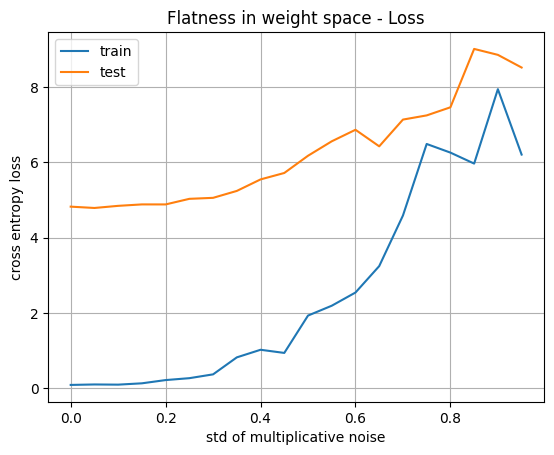

In [123]:
plt.plot(sigmas, losses, label='train')
plt.plot(sigmas, test_losses, label='test')
plt.title('Flatness in weight space - Loss')
plt.xlabel("std of multiplicative noise")
plt.ylabel("cross entropy loss")
plt.legend()
plt.grid()
plt.savefig(f"Figure/Flatness {name1} loss")
plt.show()

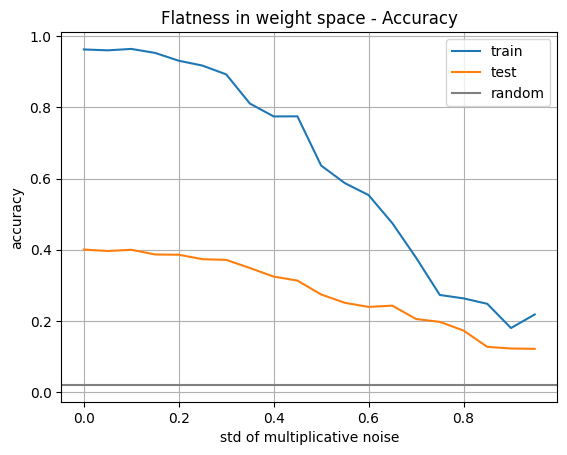

In [124]:
plt.plot(sigmas, accs, label='train')
plt.plot(sigmas, test_accs, label='test')
plt.title('Flatness in weight space - Accuracy')
plt.xlabel("std of multiplicative noise")
plt.ylabel("accuracy")
plt.axhline(0.02, color="grey", label="random")
plt.grid()

plt.legend()
plt.savefig(f"Figure/Flatness {name1} accuracy")
plt.show()

# Masking

In [125]:
#model1 = models.resnet18(weights='IMAGENET1K_V1')
#model1.fc = nn.Linear(512, num_classes, bias=True)

#model2 = models.resnet18(weights='IMAGENET1K_V1')
#model2.fc = nn.Linear(512, num_classes, bias=True)

#model1.to(device)
#model2.to(device)

#loss_fn = torch.nn.CrossEntropyLoss()

#optimizer1 = torch.optim.AdamW(model1.parameters())

In [126]:
def mask(dataloader, model, loss_fn, max_b = None, dx=10, dy=10, black=None):
    if black is None:
        black = 0

    if max_b is None:
      max_b = len(dataloader)

    mean_loss = 0
    correct = 0
    size = 0
    
    for idx, (img, label) in enumerate(dataloader):
        B, C, W, H = img.shape
        x, y = np.random.randint(W - dx), np.random.randint(H - dy)

        img[:, :, x: x + dx, y: y + dy] = black
        img, label = img.to(device), label.to(device)

        pred = model(img)
        loss = loss_fn(pred, label)
        mean_loss += loss.item()
        correct += (pred.argmax(1) == label).type(torch.float).sum().item()

        size += len(img)
        
        if idx + 1 >= max_b:
          break
      
    return mean_loss/max_b , correct/size


In [ ]:
import copy
sizes = [x for x in range(0, 100, 5)]
dxs, dys = copy.copy(sizes), copy.copy(sizes)


max_b = None
iters = 10

losses, accs= [], []
test_losses, test_accs = [], []

for dx, dy in zip(dxs,dys):
    
    print(dx, dy)
    loss, acc, test_loss, test_acc = 0,0,0,0

    for i in range(iters):
#         print(i)
        loss_temp, acc_temp = mask(dl, model1, loss_fn, max_b = max_b, dx = dx, dy = dy, black=None)
        test_loss_temp, test_acc_temp = mask(test_dl, model1, loss_fn, max_b = max_b, dx = dx, dy = dy, black=None)
        
        loss += loss_temp
        acc += acc_temp
        test_loss += test_loss_temp
        test_acc += test_acc_temp
        
    loss /= iters
    test_loss /= iters
    acc /= iters
    test_acc/= iters
    
    losses.append(loss)
    accs.append(acc)
    test_losses.append(test_loss)
    test_accs.append(test_acc)

0 0
0
1
2
3
4
5
6
7
8
9
5 5
0
1
2
3
4
5
6
7
8
9
10 10
0
1
2
3
4
5
6
7
8
9
15 15
0
1
2
3
4
5
6
7
8
9
20 20
0
1
2
3
4
5
6
7
8
9
25 25
0
1
2
3
4
5
6
7
8
9
30 30
0
1
2
3
4
5
6
7
8
9
35 35
0
1
2
3
4
5
6
7
8
9
40 40
0
1
2
3
4
5
6
7
8
9
45 45
0
1
2
3
4
5
6
7
8
9
50 50
0
1
2
3
4
5
6
7
8
9
55 55
0
1
2
3
4
5
6
7
8
9
60 60
0


In [ ]:
mask_json = {
    'dxs': dxs,
    'dys': dys,
    'iters': iters,
    'losses': losses,
    'test_losses': test_losses,
    'accuracies': accs,
    'test_accuracies': test_accs,
    'model': name1,
}

path = f"Logged robustness/mask_{name1}.json"


with open(path, "w") as file:
    json.dump(mask_json, file)

In [ ]:
plt.plot(dxs, losses, label='train')
plt.plot(dxs, test_losses, label='test')
plt.title('Masking of images - Loss')

plt.legend()
plt.grid()
plt.savefig(f"Figure/masking {name1} loss")
plt.show()

In [ ]:
plt.plot(dxs, accs, label='train')
plt.plot(dxs, test_accs, label='test')
plt.title('Masking of images - Accuracy')
plt.axhline(0.02, color="grey", label="random")

plt.legend()
plt.grid()
plt.ylim(0, 1)

plt.savefig(f"Figure/masking {name1} accuracy")
plt.show()